# Demonstration: Trilateration With Noise!

In lecture, we learned how the GPS receiver determines its location once it knows the distance of the various signaling beacons from itself.
This method is called *trilateration*.

In this demonstration, we're going to further explore the connection between trilateration and least squares through a toy problem with four beacons and one GPS receiver.

We are given *three* possible sets of measurements for the distances of each of the beacons from the receiver:

1. First, the ideal set of measurements. $d_1 = d_2 = d_3 = d_4 = 5$.
2. Next, a set of imperfect measurements. $d_1 = 5, d_2 = 4.5, d_3 = 5, d_4 = 5.5$.
3. Finally, a set of mostly perfect measurements, but $d_1$ is a very bad measurement. We have $d_1 = 7.5$ and $d_2 = d_3 = d_4 = 5$.

First, we set up some notation for the positions of the beacons, as well as their respective distances from the receivers.

In [1]:
from utils import *

ideal_distances = [5, 5, 5, 5]
imperfect_distances = [5.5, 4.5, 5, 5]
one_bad_distances = [7.5, 5, 5, 5]

#these are the coordinates of the beacons
positions = np.array([
    [0, -5],
    [-5 / 2, 5 * np.sqrt(3) / 2],
    [0, 5],
    [5 / 2, 5 * np.sqrt(3) / 2],
])

xpositions = positions[:, 0]
ypositions = positions[:, 1]

# setup to make the helper functions work
register(positions=positions)
register(xpositions=xpositions)
register(ypositions=ypositions)

### Part (c)

Now, for each of the three above cases, let's plot a circle for each beacon whose radius corresponds to the reported distance of the receiver. The intersection of the circles will tell us, intuitively, where the receiver is located! (Note that the circles do not necessarily intersect at one point for all three of the cases. Think about what this means).

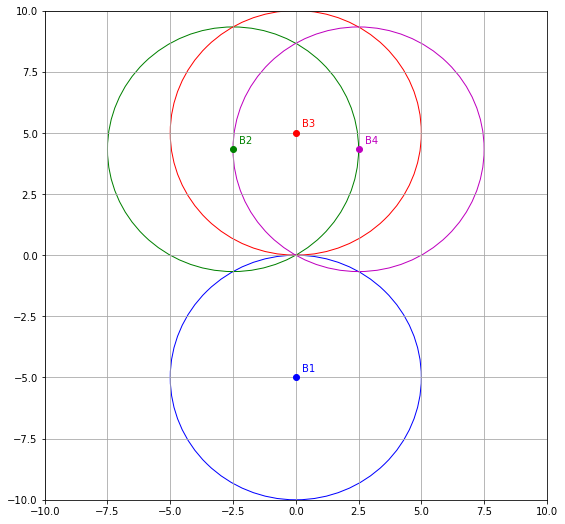

In [2]:
plot(ideal_distances)

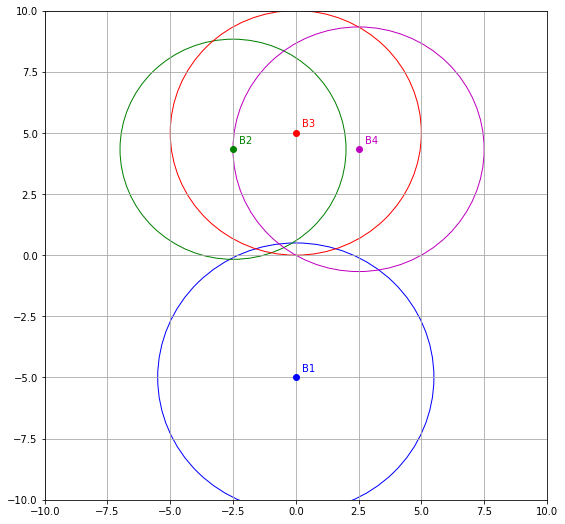

In [3]:
plot(imperfect_distances)

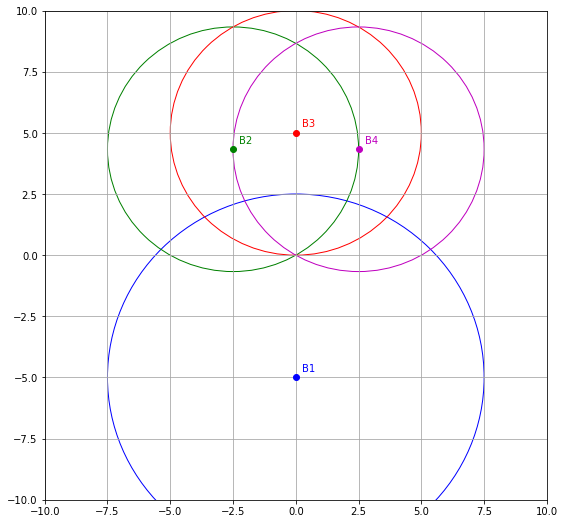

In [4]:
plot(one_bad_distances)

### Part (d)

Now, let's solve for the location of the receiver, $\begin{bmatrix}x \\ y\end{bmatrix}$, using least squares.

Recall that we made the system of equations linear by subtracting the equation for the first beacon from each of the equations for the other beacons.

This will result in the system of equations:
\begin{equation}
A\begin{bmatrix}x \\ y \end{bmatrix} = \vec{b}
\end{equation}

You will define $A$ and $\vec{b}$ in the code blocks below.

In [5]:
A = np.zeros((3,2))

A[0][0] = 2*(xpositions[0] - xpositions[1])
A[0][1] = 2*(ypositions[0] - ypositions[1])
A[1][0] = 2*(xpositions[0] - xpositions[2])
A[1][1] = 2*(ypositions[0] - ypositions[2])
A[2][0] = 2*(xpositions[0] - xpositions[3])
A[2][1] = 2*(ypositions[0] - ypositions[3])
print(A)

[[  5.         -18.66025404]
 [  0.         -20.        ]
 [ -5.         -18.66025404]]


### Part (e)
Fill in the entries of `b` in the below function to correspond to the entries of $\vec{b}$ from the problem.

In [6]:
def make_b(distances):
    """
    Since `b` depends on `distances`, we implement it using a function, so we can generate
    different `b` vectors depending of which set of distances we are interested in,
    (i.e. ideal_distances, imperfect_distances, or one_bad_distances)
    
    Examples of how to call the function:
    make_values(ideal_distances) OR
    make_values(imperfect_distances) OR
    make_values(one_bad_distances)
    """

    b = np.zeros(3)
    
    b[0] = xpositions[0]**2 - xpositions[1]**2 + ypositions[0]**2 - ypositions[1]**2 - distances[0]**2 +distances[1]**2
    b[1] = xpositions[0]**2 - xpositions[2]**2 + ypositions[0]**2 - ypositions[2]**2 - distances[0]**2 +distances[2]**2
    b[2] = xpositions[0]**2 - xpositions[3]**2 + ypositions[0]**2 - ypositions[3]**2 - distances[0]**2 + distances[3]**2

    return b

make_b(ideal_distances)

array([3.55271368e-15, 0.00000000e+00, 3.55271368e-15])

### Part (f)

Now, calculate the linear least squares estimate for the `ideal_distances` data and plot the results. We have given you code for the implementation for this part.

In [7]:
def estimate_position(distances):
    U1 = np.dot(A.T, A)
    U2 = np.dot(A.T, make_b(distances))
    least_squares_sol = np.dot(np.linalg.inv(U1),U2)
    return least_squares_sol

estimate_position(ideal_distances)

array([ 8.59260618e-33, -1.20930181e-16])

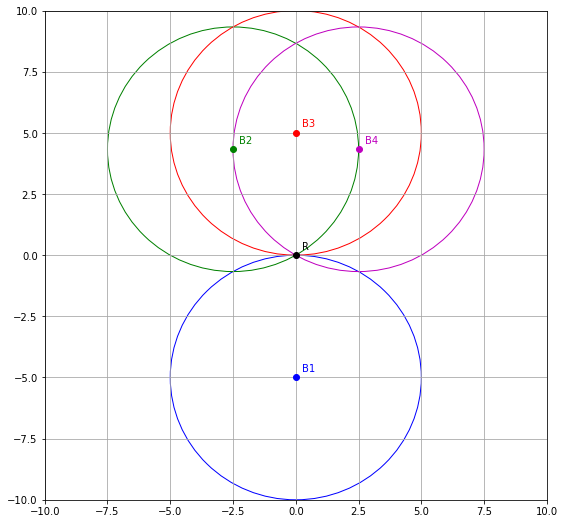

In [8]:
plot(ideal_distances)
plot_point(estimate_position(ideal_distances))

What about for the `imperfect_distances` and `one_bad_distances`? Copy and modify the above code to compute and plot the least-squares trilateration solutions for those two cases, and comment on the quality of the solution in each case.

In particular, for `one_bad_distances`, is the solution the best possible? In other words, if you were trying to identify your position from the graph by hand, would you have chosen the same point that our trilateration solution did?

array([-0.475     ,  0.35531308])

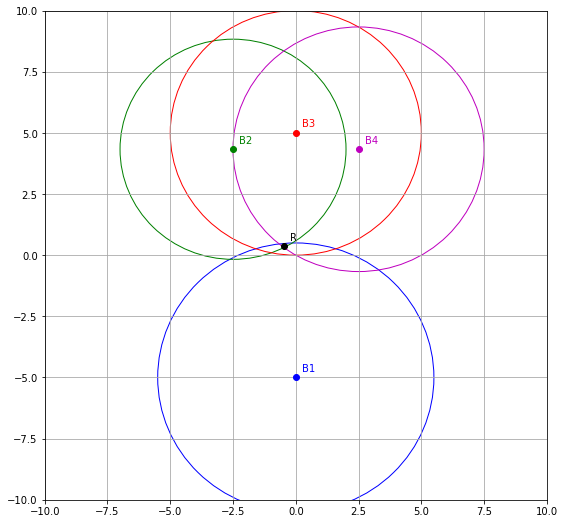

In [9]:
### imperfect_distances case

plot(imperfect_distances)
plot_point(estimate_position(imperfect_distances))
estimate_position(imperfect_distances)

array([-1.16085294e-16,  1.63375527e+00])

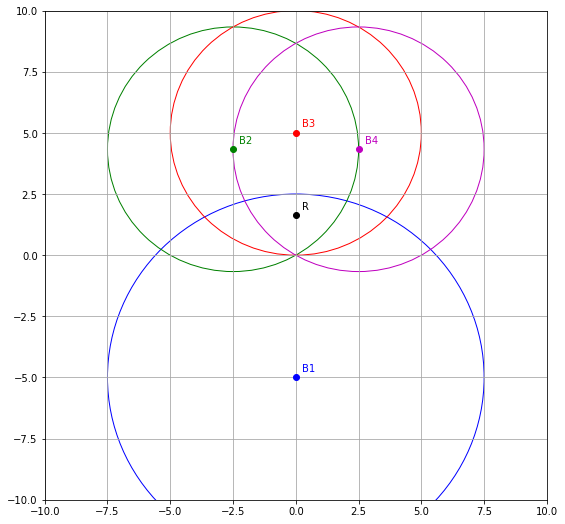

In [10]:
### one_bad_distances case
plot(one_bad_distances)
plot_point(estimate_position(one_bad_distances))
estimate_position(one_bad_distances)

### Part (g)

You should see that linearizing and solving least squares did not always do well in the above cases. Now, let's try something else.
For any candidate location of the receiver, we can define the distance from $i_{th}$ beacon as $\hat{d}_i$ and define $\vec{\hat{d}}$ as:

$$\vec{\hat{d}} = \begin{bmatrix}\hat{d}_1\\\hat{d}_2\\\hat{d}_3\\\hat{d}_4\end{bmatrix}$$

So we might want to minimize the following:

$$\sum_{i=1}^4(d_i-\hat{d}_i)^2$$

Let's make a plot that will help us visualize this. $(x,y)$ in the plot correspond to candidate positions of the receivers and the color corresponds to the cost.

Let's first plot the costs when the `one_bad_distances` data is used. You should see that this cost is minimized at $(0,0)$.

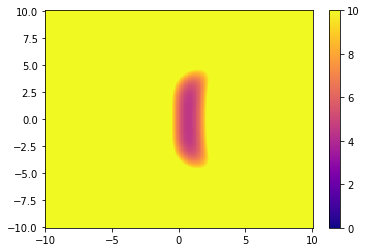

In [11]:
def cost_function(point, actual_distances):
    cost = 0
    for pos, actual_distance in zip(positions, actual_distances):
        cost += (distance_between_points(point, pos) - actual_distance) ** 2
    return cost


plot_cost(one_bad_distances, cost_function)

Let's verify numerically that the above approach does indeed do better than the least-squares trilateration approach in the `one_bad_distances` case. Use `cost_function` to compare the cost of `(0, 0)` with the cost of your estimated position obtained from the least-squares solution in all three cases. When does least squares do worst, compared to the new approach?

In [12]:
for distances in [ideal_distances, imperfect_distances, one_bad_distances]:
    print("cost at (0, 0):", cost_function([0, 0], distances))
    print("cost at coordinates determined by least squares estimate", cost_function(estimate_position(distances), distances))
    print("\n")

cost at (0, 0): 0.0
cost at coordinates determined by least squares estimate 0.0


cost at (0, 0): 0.5
cost at coordinates determined by least squares estimate 0.12767439181123572


cost at (0, 0): 6.25
cost at coordinates determined by least squares estimate 6.920128282445373


